# Predicting Stock Markets

## Setup

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
from sqlalchemy import create_engine # database connection
from IPython.display import display
import requests

%matplotlib inline

## Database

In [2]:
class Database(object):
    
    def __init__(self):
        
        self.engine = create_engine('sqlite:///datalake.db')


    def save(self, tablename, data, behavior='fail', index=False):
        
        '''behavior options:
        fail: If table exists, do nothing.
        replace: If table exists, drop it, recreate it, and insert data.
        append: If table exists, insert data. Create if does not exist.'''
        
        data.to_sql(tablename, self.engine, if_exists=behavior, index=index)
    
    def search_ticker(self, query):
        return pd.read_sql("SELECT security_name, ticker FROM 'Master Data' WHERE security_name LIKE '%{}%' OR ticker LIKE '%{}%'".format(query, query), self.engine)
    
    def retrieve_prices(self, ticker):
        ticker = ticker.upper()
        prices = pd.read_sql("SELECT * from '{}'".format(ticker), self.engine)
        prices = prices.set_index('date')
        return prices

In [3]:
database = Database()

## Data Connections
In the beginning I'm connecting with Yahoo using the Pandas DataReader for easy acces to stock data

In [4]:
start = datetime(2000,1,1)
end = datetime(2016,10,1)

stock = "aapl"
stock_data = web.DataReader(stock, "yahoo", start, end)

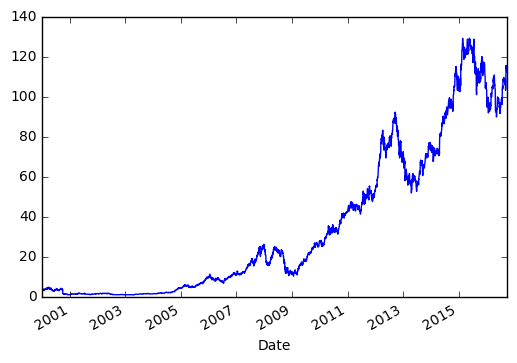

In [5]:
stock_data["Adj Close"].plot()

### Wikipedia

In [6]:
# Get Current S&P 500 Stocks
r = requests.get('https://extraction.import.io/query/extractor/d7417831-edc5-4fd1-9b57-26606728d3a0?_apikey=c5d8f713017f49ea8b77160a194b731468328172572b117710aa880cbb30e999f638bcf59fe2160122c8ef8fccc7a56e1f0042111d2be5509a6478e40fae5506206ce53f1fa15da66bc2c35003806243&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FList_of_S%2526P_500_companies')
sp500 = pd.DataFrame(r.json()['extractorData']['data'][0]['group'])
sp500['Ticker Symbol'] = sp500['Ticker Symbol'].apply(lambda x: (x[0]['text']))

### Intrino
The data connection with Intrinio will be used in production, because they allow redistribution of certain datasets.

In [7]:
import requests
import json

class Intrinio(object):
    
    def __init__(self):
        
        self.user = 'b8f16afb02891a7fc1085118fd64ad47'
        self.password = '5ad4db89b891c478803e731c8b3ff2d0'
    
    def request(self, url, payload={}):
        
        r = requests.get(url, params=payload, auth=(self.user, self.password))
    
        if r.status_code == 200:

            return json.loads(r.text)
        
        else:
            raise RuntimeError('An error has occurred while requesting data. Status Code:{}'.format(r.status_code))
    
    def extract_data(self, response):
        
        return pd.DataFrame(response['data'])
    
    def multiple_pages(self, url, parameters={}):
        response = self.request(url, parameters)
        data = self.extract_data(response)

        if response['total_pages'] > 1:
            i = 2
            
            while i <= response['total_pages']:
                
                parameters['page_number'] = i
                data = data.append(self.request(url, parameters)['data'], ignore_index=True)
                i += 1
        
        return data

    def request_new_prices(self, ticker):

        response = self.request('https://api.intrinio.com/prices', {'identifier': ticker, 'sort_order':'asc'})
        return self.extract_data(response).set_index('date')

In [8]:
intrinio = Intrinio()

In [9]:
# Refresh Master Data - Ticker and Company Name
class MasterData(object):
    
    def __init__(self, data_provider, database, refresh=False):
        
        self.data_provider = data_provider
        self.database = database
        
        if refresh == True:
            master_data = self.data_provider.multiple_pages('https://api.intrinio.com/securities')
            self.data = master_data
            self.database.save('Master Data', master_data, 'replace')
            print('Master Data was refreshed.')
        else:
            self.data = pd.read_sql("SELECT * FROM 'Master Data'", self.database.engine)

In [10]:
master_data = MasterData(intrinio, database)

In [11]:
pd.read_sql("SELECT * FROM 'Master Data' WHERE security_name LIKE '%Apple%'", database.engine)

,delisted_security,etf,financial_status,last_crsp_adj_date,listing_exchange,market_category,primary_security,round_lot_size,security_class,security_name,security_type,stock_exchange,ticker
0,0,0,N,2016-08-04,Nasdaq,Global Select Market,1,100,None,Apple Inc. - Common Stock,Common Stock,NasdaqGS,AAPL
1,0,0,None,2016-09-30,NYSE,None,1,100,None,"Apple Hospitality REIT, Inc. Common Shares",Common Shares,NYSE,APLE
2,0,0,None,2016-09-09,NYSE,None,1,100,None,"Dr Pepper Snapple Group, Inc Dr Pepper Snapple...",Common Stock,NYSE,DPS
3,0,0,None,2000-03-08,NYSE,None,1,100,None,"Maui Land & Pineapple Company, Inc. Common Stock",Common Stock,NYSE,MLP


In [12]:
class Stock(object):

    def __init__(self, ticker, data_provider=intrinio, database=database):
        
        self.data_provider = data_provider
        self.database = database
        self.ticker = ticker.upper()
        self.company_name = self.retrieve_company_name(ticker)
        
        try:
            # TODO: Check for current date
            self.prices()
        except:
            self.download_prices()
            
    def retrieve_company_name(self, ticker):
        
        try:
            company_name = pd.read_sql("SELECT security_name FROM 'Master Data' WHERE ticker = '{}'".format(ticker), self.database.engine).ix[0][0]
            return company_name
        
        except:
            raise ValueError('The ticker {} you entered is not valid.'.format(ticker))
    
    def compute_daily_ret(self, data):
        data = data['adj_close']
        daily_ret = data.copy()
        daily_ret[1:] = (data[1:] / data[:-1].values) - 1
        daily_ret.ix[0] = 0
        return daily_ret
    
    def download_prices(self):
        
        prices = self.data_provider.request_new_prices(self.ticker)
        
        if len(prices) < 1:
            raise RuntimeError('An error occurred, while downloading the prices.')
        
        prices['daily_ret'] = self.compute_daily_ret(prices)
        self.database.save(self.ticker, prices, 'replace', 'date')
        
    def prices(self):
        prices = self.database.retrieve_prices(self.ticker)
        return prices

## Feature Engineering

In [13]:
def train_test_split(X, y, test_size=0.2, target='daily_ret'):
        index = int(len(X) * (1 - test_size))
        return X[:index], X[index:], y[:index][target].values, y[index:][target].values

According to "Stock Market Prediction with multiple classifiers" to parameters have to be chosen for the rolling window technique - d (number of input days) and t (separation). Since executing trades very frequently, I chose t to be equal to seven.


I'm implementing the Feature Engineering steps as custom sklearn transformers to be able to use GridSearch and FeatureUnion for hyper-parameter tuning. Source: http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/ and http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

In [15]:
np.arange(0, 6)

array([0, 1, 2, 3, 4, 5])

In [16]:
class Windowing(BaseEstimator, TransformerMixin):
    '''
    http://stockcharts.com/school/doku.php?st=roc&id=chart_school:technical_indicators:rate_of_change_roc_and_momentum
    '''
    def __init__(self, t=5, feature='daily_ret'):
        
        self.t = t
        self.feature = feature
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        columns = ['{}_{}'.format(self.feature, 0)]
        X.loc[:,'{}_{}'.format(self.feature, 0)] = X[:][self.feature].values
        for i in np.arange(1, self.t+1):
            X.loc[i:,'{}_{}'.format(self.feature, i)] = X[:-i][self.feature].values
            X.loc[:i,'{}_{}'.format(self.feature, i)] = 0
            columns.append('{}_{}'.format(self.feature, i))
        return X[columns]

K compares where a security’s price closed relative to its price range over a given time period. D is the moving average of K, while slow D is the moving average of D.

In [17]:
class K(BaseEstimator, TransformerMixin):
    
    def __init__(self, t1=14):
        
        self.t1 = t1
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        rolling = X['adj_close'].rolling(window=self.t1)
        X['K'] = (X['adj_close']-rolling.min())/(rolling.max()-rolling.min())*100
        X['K'].loc[:self.t1 - 1] = 50 # Imputing missing values
        return X[['K']]

class D(BaseEstimator, TransformerMixin):
    
    def __init__(self, t2=3):
        
        self.t2 = t2
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        rolling = X['K'].rolling(window=self.t2)
        X['D'] = rolling.mean()
        X['D'].loc[:self.t2-1] = 50
        return X[['D']]
    
class Slow_D(BaseEstimator, TransformerMixin):
    
    def __init__(self, t3=3):
        
        self.t3 = t3
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        rolling = X['D'].rolling(window=self.t3)
        X['slow_D'] = rolling.mean()
        X['slow_D'].loc[:self.t3-1] = 50
        return X[['slow_D']]

Momentum measures the amount that a security’s price has changed over a given time span. Price rate-of-change. It displays the diference between the current price and the price n days ago. Larry William’s R. It is a momentum indicator that measures overbought/oversold levels.

In [18]:
class Momentum(BaseEstimator, TransformerMixin):
    '''
    http://stockcharts.com/school/doku.php?st=roc&id=chart_school:technical_indicators:rate_of_change_roc_and_momentum
    '''
    def __init__(self, t=12):
        
        self.t = t
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['momentum_{}'.format(self.t)] = X['adj_close'][self.t:] - X['adj_close'][:-self.t].values
        X['momentum_{}'.format(self.t)].loc[:self.t] = 0
        return X[['momentum_{}'.format(self.t)]]

class ROC(BaseEstimator, TransformerMixin):
    '''
    http://stockcharts.com/school/doku.php?st=roc&id=chart_school:technical_indicators:rate_of_change_roc_and_momentum
    '''
    def __init__(self, t=12):
        
        self.t = t
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['ROC_{}'.format(self.t)] = (X['adj_close'][self.t:] / X['adj_close'][:-self.t].values) * 100
        X['ROC_{}'.format(self.t)].loc[:self.t] = 0
        return X[['ROC_{}'.format(self.t)]]

class Williams_R(BaseEstimator, TransformerMixin):
    '''
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:williams_r
    '''
    def __init__(self, t=14):
        
        self.t = t
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        rolling_low = X['adj_low'].rolling(window=self.t)
        rolling_high = X['adj_high'].rolling(window=self.t)
        X['williams_r'] = (rolling_high.max()-X['adj_close'])/(rolling_high.max()-rolling_low.min()) * 100
        X['williams_r'].loc[:self.t-1] = 50
        return X[['williams_r']]

class ADL(BaseEstimator, TransformerMixin):
    '''
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:accumulation_distribution_line
    '''
    def __init__(self, t=2):
        self.t = t
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        money_flow_multiplier = ((X['adj_close'] - X['adj_low']) - (X['adj_high'] - X['adj_close'])) / (X['adj_high'] - X['adj_low'])
        money_flow_multiplier = money_flow_multiplier.fillna(1) # Whenever low and high are identical one is substituted to avioid na
        money_flow_volume = money_flow_multiplier * X['adj_volume']
        rolling = money_flow_volume.rolling(window=self.t)
        X['ADL'] = rolling.sum()
        X['ADL'].iloc[:self.t-1] = money_flow_volume.iloc[:self.t-1].cumsum()
        return X[['ADL']]

Disparity is a momentum indicator that captures distance of current price and the moving average of t days.

In [19]:
class Disparity(BaseEstimator, TransformerMixin):
    '''
    http://www.investopedia.com/ask/answers/121214/why-disparity-index-important-traders-and-analysts.asp
    '''
    def __init__(self, t=5):
        self.t = t
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        rolling = X['adj_close'].rolling(window=self.t)
        X['disparity_{}'.format(self.t)] = X['adj_close'] / rolling.mean() * 100
        X['disparity_{}'.format(self.t)].loc[:self.t-1]=100
        return X[['disparity_{}'.format(self.t)]]

class PPO(BaseEstimator, TransformerMixin):
    '''
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:price_oscillators_ppo
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        EMA_12 = X['adj_close'].ewm(com=12)
        EMA_26 = X['adj_close'].ewm(com=26)
        X['PPO'] = ((EMA_12.mean() - EMA_26.mean())/EMA_26.mean()) * 100
        return X[['PPO']]

class CCI(BaseEstimator, TransformerMixin):
    '''
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:commodity_channel_index_cci
    '''
    def __init__(self, t=20):
        self.t = t
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        typical_price = (X['adj_high'] + X ['adj_low'] + X['adj_close'])/3
        rolling_tp = typical_price.rolling(window=self.t)
        mad = lambda x: np.fabs(x - x.mean()).mean()

        X['CCI'] = (typical_price - rolling_tp.mean())/(0.015* rolling_tp.apply(mad))
        X['CCI'].loc[:self.t-1] = 0
        return X[['CCI']]

class RSI(BaseEstimator, TransformerMixin):
    '''
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:commodity_channel_index_cci
    '''
    def __init__(self, t=14):
        self.t = t
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        delta = Momentum(1).transform(X)['momentum_1']
        dUp, dDown = delta.copy(), delta.copy()
        dUp[dUp < 0] = 0
        dDown[dDown > 0] = 0

        RolUp = dUp.rolling(window=self.t).mean()
        RolDown = dDown.rolling(window=self.t).mean().abs()

        RS = RolUp / RolDown
        X['RSI'] = 100 - 100/(1+RS)
        X['RSI'].loc[:self.t-1] = 50
        return X[['RSI']]

In [20]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[]):
        self.columns = columns
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        return X[self.columns]

class Scaling(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[]):
        self.columns = columns
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X = X.copy()
        for column in self.columns:
            X[column] = np.log(X[column])
        return X

class ModelTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, model):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return pd.DataFrame(self.model.predict(X))

### Data Preparation

In [235]:
ticker_sector = {'A': 4, 'AA': 7, 'AAL': 5, 'AAP': 0, 'AAPL': 6, 'ABBV': 4, 'ABC': 4, 'ABT': 4, 'ACN': 6, 'ADBE': 6, 
'ADI': 6, 'ADM': 1, 'ADP': 6, 'ADS': 6, 'ADSK': 6, 'AEE': 9, 'AEP': 9, 'AES': 9, 'AET': 4, 'AFL': 3, 
'AGN': 4, 'AIG': 3, 'AIV': 3, 'AIZ': 3, 'AJG': 3, 'AKAM': 6, 'ALK': 5, 'ALL': 3, 'ALLE': 5, 'ALXN': 4,
'AMAT': 6, 'AME': 5, 'AMG': 3, 'AMGN': 4, 'AMP': 3, 'AMT': 3, 'AMZN': 0, 'AN': 0, 'ANTM': 4, 'AON': 3,
'APA': 2, 'APC': 2, 'APD': 7, 'APH': 5, 'ATVI': 6, 'AVB': 3, 'AVGO': 6, 'AVY': 7, 'AWK': 9, 'AXP': 3,
'AYI': 5, 'AZO': 0, 'BA': 5, 'BAC': 3, 'BAX': 4, 'BBBY': 0, 'BBT': 3, 'BBY': 0, 'BCR': 4, 'BDX': 4,
'BEN': 3, 'BF-B': 1, 'BHI': 2, 'BIIB': 4, 'BK': 3, 'BLK': 3, 'BLL': 7, 'BMY': 4, 'BRK-B': 3, 'BSX': 4,
'BWA': 0, 'BXP': 3, 'C': 3, 'CA': 6, 'CAG': 1, 'CAH': 4, 'CAT': 5, 'CB': 3, 'CBG': 3, 'CBS': 0, 
'CCI': 3, 'CCL': 0, 'CELG': 4, 'CERN': 4, 'CF': 7, 'CFG': 3, 'CHD': 1, 'CHK': 2, 'CHRW': 5, 'CI': 4,
'CINF': 3, 'CL': 1, 'CLX': 1, 'CMA': 3, 'CMCSA': 0, 'CME': 3, 'CMG': 0, 'CMI': 5, 'CMS': 9, 'CNC': 4,
'CNP': 9, 'COF': 3, 'COG': 2, 'COH': 0, 'COL': 5, 'COP': 2, 'COST': 1, 'CPB': 1, 'CRM': 6,
'CSCO': 6, 'CSRA': 6, 'CSX': 5, 'CTAS': 5, 'CTL': 8, 'CTSH': 6, 'CTXS': 6, 'CVS': 1, 'CVX': 2, 
'CXO': 2, 'D': 9, 'DAL': 5, 'DD': 7, 'DE': 5, 'DFS': 3, 'DG': 0, 'DGX': 4, 'DHI': 0, 'DHR': 5, 
'DIS': 0, 'DISCA': 0, 'DISCK': 0, 'DLPH': 0, 'DLR': 3, 'DLTR': 0, 'DNB': 5, 'DO': 2, 'DOV': 5, 
'DOW': 7, 'DPS': 1, 'DRI': 0, 'DTE': 9, 'DUK': 9, 'DVA': 4, 'DVN': 2, 'EA': 6, 'EBAY': 6, 'ECL': 7,
'ED': 9, 'EFX': 3, 'EIX': 9, 'EL': 1, 'EMC': 6, 'EMN': 7, 'EMR': 5, 'ENDP': 4, 'EOG': 2, 'EQIX': 6,
'EQR': 3, 'EQT': 2, 'ES': 9, 'ESRX': 4, 'ESS': 3, 'ETFC': 3, 'ETN': 5, 'ETR': 9, 'EW': 4, 'EXC': 9,
'EXPD': 5, 'EXPE': 0, 'EXR': 3, 'F': 0, 'FAST': 5, 'FB': 6, 'FBHS': 5, 'FCX': 7, 'FDX': 5, 'FE': 9, 
'FFIV': 6, 'FIS': 6, 'FISV': 6, 'FITB': 3, 'FL': 0, 'FLIR': 5, 'FLR': 5, 'FLS': 5, 'FMC': 7, 
'FOX': 0, 'FOXA': 0, 'FRT': 3, 'FSLR': 6, 'FTI': 2, 'FTR': 8, 'GD': 5, 'GE': 5, 'GGP': 3,
'GILD': 4, 'GIS': 1, 'GLW': 5, 'GM': 0, 'GOOG': 6, 'GOOGL': 6, 'GPC': 0, 'GPN': 6, 'GPS': 0, 
'GRMN': 0, 'GS': 3, 'GT': 0, 'GWW': 5, 'HAL': 2, 'HAR': 0, 'HAS': 0, 'HBAN': 3, 'HBI': 0, 'HCA': 4,
'HCN': 3, 'HCP': 3, 'HD': 0, 'HES': 2, 'HIG': 3, 'HOG': 0, 'HOLX': 4, 'HON': 5, 'HOT': 0, 'HP': 2,
'HPE': 6, 'HPQ': 6, 'HRB': 3, 'HRL': 1, 'HRS': 6, 'HSIC': 4, 'HST': 3, 'HSY': 1, 'HUM': 4, 'IBM': 6,
'ICE': 3, 'IFF': 7, 'ILMN': 4, 'INTC': 6, 'INTU': 6, 'IP': 7, 'IPG': 0, 'IR': 5, 'IRM': 5, 
'ISRG': 4, 'ITW': 5, 'IVZ': 3, 'JBHT': 5, 'JCI': 0, 'JEC': 5, 'JNJ': 4, 'JNPR': 6, 'JPM': 3, 
'JWN': 0, 'K': 1, 'KEY': 3, 'KHC': 1, 'KIM': 3, 'KLAC': 6, 'KMB': 1, 'KMI': 2, 'KMX': 0, 'KO': 1,
'KORS': 0, 'KR': 1, 'KSS': 0, 'KSU': 5, 'L': 3, 'LB': 0, 'LEG': 5, 'LEN': 0, 'LH': 4, 'LKQ': 0, 
'LLL': 5, 'LLTC': 6, 'LLY': 4, 'LM': 3, 'LMT': 5, 'LNC': 3, 'LOW': 0, 'LRCX': 6, 'LUK': 3, 'LUV': 5,
'LVLT': 8, 'LYB': 7, 'M': 0, 'MA': 6, 'MAC': 3, 'MAR': 0, 'MAS': 5, 'MAT': 0, 'MCD': 0, 'MCHP': 6, 
'MCK': 4, 'MCO': 3, 'MDLZ': 1, 'MDT': 4, 'MET': 3, 'MHK': 0, 'MJN': 1, 'MKC': 1, 'MLM': 7, 'MMC': 3, 
'MMM': 5, 'MNK': 4, 'MNST': 1, 'MO': 1, 'MON': 7, 'MOS': 7, 'MPC': 2, 'MRK': 4, 'MRO': 2, 'MS': 3, 
'MSFT': 6, 'MSI': 6, 'MTB': 3, 'MU': 6, 'MUR': 2, 'MYL': 4, 'NAVI': 3, 'NBL': 2, 'NDAQ': 3,
'NEM': 7, 'NFLX': 6, 'NFX': 2, 'NI': 9, 'NKE': 0, 'NLSN': 5, 'NOC': 5, 'NOV': 2, 'NRG': 9, 'NSC': 5, 
'NTAP': 6, 'NTRS': 3, 'NUE': 7, 'NVDA': 6, 'NWL': 0, 'NWS': 0, 'NWSA': 0, 'O': 3, 'OI': 7, 'OKE': 2, 
'OMC': 0, 'ORCL': 6, 'ORLY': 0, 'OXY': 2, 'PAYX': 6, 'PBCT': 3, 'PBI': 5, 'PCAR': 5, 'PCG': 9, 'PCLN': 0, 
'PDCO': 4, 'PEG': 9, 'PEP': 1, 'PFE': 4, 'PFG': 3, 'PG': 1, 'PGR': 3, 'PH': 5, 
'PHM': 0, 'PKI': 4, 'PLD': 3, 'PM': 1, 'PNC': 3, 'PNR': 5, 'PNW': 9, 'PPG': 7, 
'PPL': 9, 'PRGO': 4, 'PRU': 3, 'PSA': 3, 'PSX': 2, 'PVH': 0, 'PWR': 5, 'PX': 7, 'PXD': 2, 
'PYPL': 6, 'QCOM': 6, 'QRVO': 6, 'R': 5, 'RAI': 1, 'RCL': 0, 'REGN': 4, 'RF': 3, 'RHI': 5, 'RHT': 6, 
'RIG': 2, 'RL': 0, 'ROK': 5, 'ROP': 5, 'ROST': 0, 'RRC': 2, 'RSG': 5, 'RTN': 5, 'SBUX': 0, 'SCG': 9,
'SCHW': 3, 'SE': 2, 'SEE': 7, 'SHW': 7, 'SIG': 0, 'SJM': 1, 'SLB': 2, 'SLG': 3, 'SNA': 0, 'SNI': 0,
'SO': 9, 'SPG': 3, 'SPGI': 3, 'SPLS': 0, 'SRCL': 5, 'SRE': 9, 'STI': 3, 'STJ': 4, 'STT': 3, 'STX': 6,
'STZ': 1, 'SWK': 0, 'SWKS': 6, 'SWN': 2, 'SYF': 3, 'SYK': 4, 'SYMC': 6, 'SYY': 1, 'T': 8, 'TAP': 1,
'TDC': 6, 'TDG': 5, 'TEL': 6, 'TGNA': 0, 'TGT': 0, 'TIF': 0, 'TJX': 0, 'TMK': 3, 'TMO': 4,
'TRIP': 0, 'TROW': 3, 'TRV': 3, 'TSCO': 0, 'TSN': 1, 'TSO': 2, 'TSS': 6, 'TWX': 0, 'TXN': 6, 'TXT': 5,
'TYC': 5, 'UA': 0, 'UAL': 5, 'UDR': 3, 'UHS': 4, 'ULTA': 0, 'UNH': 4, 'UNM': 3, 'UNP': 5, 'UPS': 5,
'URBN': 0, 'URI': 5, 'USB': 3, 'UTX': 5, 'V': 6, 'VAR': 4, 'VFC': 0, 'VIAB': 0, 'VLO': 2, 'VMC': 7, 
'VNO': 3, 'VRSK': 5, 'VRSN': 6, 'VRTX': 4, 'VTR': 3, 'VZ': 8, 'WAT': 4, 'WBA': 1, 'WDC': 6, 'WEC': 9,
'WFC': 3, 'WFM': 1, 'WHR': 0, 'WM': 5, 'WMB': 2, 'WMT': 1, 'WRK': 7, 'WU': 6, 'WY': 3, 
'WYN': 0, 'WYNN': 0, 'XEC': 2, 'XEL': 9, 'XL': 3, 'XLNX': 6, 'XOM': 2, 'XRAY': 4, 'XRX': 6, 'XYL': 5,
 'YHOO': 6, 'YUM': 0, 'ZBH': 4, 'ZION': 3, 'ZTS': 4}

In [285]:
import pandas_datareader.data as web

start = pd.Timestamp("2015-12-10")
end = pd.Timestamp("2016-01-01")
pricing = web.DataReader(list(ticker_sector.keys()), "yahoo", start, end)

In [288]:
pricing

<class 'pandas.core.panel.Panel'>
Dimensions: 499 (items) x 15 (major_axis) x 6 (minor_axis)
Items axis: A to ZTS
Major_axis axis: 2015-12-10 00:00:00 to 2015-12-31 00:00:00
Minor_axis axis: Open to Adj Close

In [287]:
pricing = pricing.transpose(2,1,0)

In [268]:
n_fwd_days=1

In [284]:
# Calculating daily Returns
returns = pricing.loc[:,:,'Adj Close'].pct_change()

# Automatically exclude all stocks, where we have inconsistent data
returns = returns.dropna(how='all', axis=0)
returns = returns.dropna(how='any', axis=1)

# Massage the DataFrame into shape
returns = returns.stack()
returns.index = returns.index.set_names(['date', 'asset'])

# Get the trading days in the dataset
trading_days = list(sorted(set([x[0] for x in returns.index.unique()])))

# Create a Returns DataFrame
Returns = pd.DataFrame(returns, columns=[1])
Returns = Returns.loc[slice(trading_days[0], trading_days[-1])]
Returns = Returns.dropna(axis=0)

# Shift the daily returns data for to benchmark requirements
y = Returns.loc[slice(trading_days[n_fwd_days], trading_days[-1])].values

X = Returns.loc[slice(trading_days[0], trading_days[-1-n_fwd_days])].copy()
X.loc[slice(trading_days[1], trading_days[-1-n_fwd_days]),2] = Returns.loc[slice(trading_days[0], trading_days[-2-n_fwd_days])].values
X.loc[slice(trading_days[2], trading_days[-1-n_fwd_days]),3] = Returns.loc[slice(trading_days[0], trading_days[-3-n_fwd_days])].values
X.loc[slice(trading_days[3], trading_days[-1-n_fwd_days]),4] = Returns.loc[slice(trading_days[0], trading_days[-4-n_fwd_days])].values

In [ ]:
X = stock.prices()[['adj_low', 'adj_high', 'adj_close','adj_volume', 'daily_ret']]

# Time delay between X and y
time_delay = 1

# Calculate the price difference between current price and price seven days prior
target_transformation = Momentum(time_delay) #
y = target_transformation.transform(X)
y.columns = ['target']
y['target'] = y['target'].apply(lambda x: 1 if x > 0 else -1)

# Training, testing split
X_train, X_test, y_train, y_test = train_test_split(X[:-time_delay], y[time_delay:], target='target')

### Data Exploration

In [ ]:
pd.DataFrame(y_train)[0].hist()

In [ ]:
from sklearn.decomposition import PCA

# Classification
pipeline = Pipeline([
        ('features', FeatureUnion([
            ('K', Pipeline([
                ('transformer', K()),
                ('scale', Scaling())
            ])),
            ('Momentum', Pipeline([
                ('transformer', Momentum()),
                ('scale', Scaling())
            ])),
            ('ROC', Pipeline([
                ('transformer', ROC()),
                ('scale', Scaling())
            ])),
            ('williams_r', Pipeline([
                ('transformer', Williams_R()),
                ('scale', Scaling())
            ])),
            ('ADL', Pipeline([
                ('transformer', ADL()),
                ('scale', Scaling())
            ])),
            ('Disparity', Pipeline([
                ('transformer', Disparity(5)),
                ('scale', Scaling())
            ])),
            ('PPO', Pipeline([
                ('transformer', PPO()),
                ('scale', Scaling())
            ])),
            ('CCI', Pipeline([
                ('transformer', CCI()),
                ('scale', Scaling())
            ])),
            ('RSI', Pipeline([
                ('transformer', RSI()),
                ('scale', Scaling())
            ]))
        ]))
    ])

In [ ]:
from pandas.tools.plotting import scatter_matrix

features = ['K', 'Momentum', 'ROC', 'Williams R', 'ADL', 'Disparity', 'PPO', 'CCI', 'RSI']
X_transformed = pd.DataFrame(pipeline.fit_transform(X_train), columns=features)
X_transformed['target'] = y_train

color_wheel = {1: "#ffff00", 
               3: "#429300"}

colors = X_transformed["target"].map(lambda x: color_wheel.get(x + 2))
scatter_matrix(X_transformed[features], color=colors, alpha=0.2, figsize=(12,12), diagonal='kde', c=None)

In [ ]:
pca = PCA(2)
result = pd.DataFrame(pca.fit_transform(X_transformed[['PPO', 'CCI', 'RSI']]))
print("Explained Variance: {}".format(pca.components_))

result['label'] = y_train
ax = result[result['label'] == 1].plot(kind='scatter', x=0, y=1, color='DarkGreen', label='Up', alpha=0.2)
result[result['label'] == -1].plot(kind='scatter', x=0, y=1, color='Yellow', label='Down', ax=ax, alpha=0.6)

## Baseline Classifier
This predictor serves as a benchmark to compare other algorithms against. New algorithms have to perform better than this predictor.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

# Classification
pipeline = Pipeline([
        ('features', FeatureUnion([
            ('daily_ret', Pipeline([
                ('windowing', Windowing(t=4, feature='daily_ret')),
                ('scale', preprocessing.RobustScaler())
            ]))
        ])),
        ('estimator', KNeighborsClassifier())
    ])

In [ ]:
params = {
    'estimator__n_neighbors': np.arange(1,10),
    'features__daily_ret__windowing__t': np.arange(4,20,2)
}

# grid_search = RandomizedSearchCV(pipeline, param_distributions=params, n_jobs=8, n_iter=16)
grid_search = GridSearchCV(pipeline, param_grid=params, n_jobs=12)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_score_)
display(grid_search.best_params_)
class_names = ['Down','Up']
classifier = grid_search.best_estimator_
y_pred = classifier.predict(X_test)

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The benchmark predict shows adequate accuracy. Cross validation for other stocks is necessary to confirm the accuracy of this predictor.

## Test Suite
This test suite is used to backtest the model using a random selection of 200 stocks. Out of these 200 stocks, 100 stocks will be from the S&P 500.

In [ ]:
import random
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# CHANGE Model Here
model = svm.SVR()
# random.seed(0)
indicies = random.sample(range(0, len(sp500)), 100)

def metrics(index):
    ticker = sp500.iloc[index][0]
    
    try:
        stock = Stock(ticker)
        features = FeatureEngineering(stock)

        model.fit(features.X_train, features.y_train)
        y_pred = model.predict(features.X_test)

        # Testing Metrics for regression
        return [ticker, mean_squared_error(features.y_test, y_pred), r2_score(features.y_test, y_pred)]
    except:
        return [ticker, None, None]
    

results = pd.DataFrame(Parallel(n_jobs=20)(delayed(metrics)(index) for index in indicies), columns=['ticker','MSE', 'R2'])

In [ ]:
results['R2'].hist(range=[-1,1])

In [ ]:
results['MSE'].hist(range=[0,0.001])

In [ ]:
"""pipeline = Pipeline([
        ('features', Pipeline([
            ('K', K()),
            ('D', D()),
            ('Slow_D', Slow_D()),
            ('momentum', Momentum()),
            ('ROC', ROC()),
            ('williams_r', Williams_R()),
            ('ADL', ADL()),
            ('disparity_5', Disparity(5)),
            ('disparity_10', Disparity(10)),
            ('PPO', PPO()),
            ('CCI', CCI()),
            ('RSI', RSI()),
            ('Windowing', Windowing())
        ])),
        ('column_deletion', ColumnDeletion(['adj_low', 'adj_close', 'adj_volume', 'adj_high'])),
        # TODO: Add feature scaling
        ('estimator', svm.SVC())
    ])"""
# grid_search = GridSearchCV(pipeline, param_grid={})
# grid_search.fit(X_train, y_train)
# grid_search.best_score_

In [ ]:
validation = pd.DataFrame(y_pred)
validation['true'] = pipeline.transform(X_test)
validation.plot(kind='scatter',x=0, y='true')